![Semillero Astrofisica](logo.PNG)

---
# Ecuaciones Diferenciales Parciales: Introducción 


Carlos Andrés del Valle (cdelv@unal.edu.co)

---

Vamos a resolver la ecuación de Schrödinger no lineal.

\begin{equation}
    i\frac{\partial}{\partial t}\psi + \frac{1}{2}\frac{\partial^2}{\partial x^2}\psi+|\psi|^2\psi=0
\end{equation}

Con condiciones de frontera periódicas
\begin{equation}
    \begin{split}
        & x\in[5,5], \quad t\in[0,\pi/2] \\
        & \psi(t,-5)=\psi(t,5) \\
        & \psi_x(t,-5)=\psi_x(t,5) \\
    \end{split}
\end{equation}

y la condición inicial
\begin{equation}
    \psi(0,x)=2sech\;x
\end{equation}

In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

#Usar doble precisión si la GPU lo soporta. Float32 por defecto.
dde.config.real.set_float64()

Using backend: tensorflow.compat.v1

2022-10-22 08:39:37.272744: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-22 08:39:37.390366: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-22 08:39:37.394441: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-22 08:39:37.394454: I tensorflow/stream_executor/cuda/cudart_stub.cc:

Instructions for updating:
non-resource variables are not supported in the long term


2022-10-22 08:39:38.586038: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-22 08:39:38.586077: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist


## 1. Definir la Ecuación a Resolver

DeepXDE no tiene números imaginarios, entonces tenemos que separar la ecuación en una parte real y una parte imaginaria
\begin{equation}
    \psi=u+iv
\end{equation}

de modo que

\begin{equation}
    \begin{split}
        & u_t+\frac{1}{2}v_{xx}+(u^2+v^2)v \\
        & v_t+\frac{1}{2}u_{xx}+(u^2+v^2)u \\
    \end{split}
\end{equation}

Para calcular derivadas parciales debemos tener en cuenta que
~~~python
    deepxde.gradients.jacobian(ys, xs, i=0, j=None)
~~~

i es la componente de la salida y j la de la entrada. La función retorna el gradiente de $ys_i$ en dirección a $xs_j$. detalles en https://deepxde.readthedocs.io/en/latest/modules/deepxde.html?highlight=grad.jacobian#deepxde.gradients.jacobian.

Para las segundas derivadas
~~~python
    deepxde.gradients.hessian(ys, xs, component=None, i=0, j=0, grad_y=None)
~~~

Calcula la matriz Hesiana: $H[i][j] = \frac{\partial^2 ys}{\partial x_i \partial x_j}$. component se usa para especificar que elemento de ys tomar:
~~~python
    ys[component]
~~~

- **grad_y:** The gradient of y w.r.t. xs. Provide grad_y if known to avoid duplicate computation. grad_y can be computed from jacobian. Even if you do not provide grad_y, there is no duplicate computation if you use jacobian to compute first-order derivatives.

Más detalles en https://deepxde.readthedocs.io/en/latest/modules/deepxde.html?highlight=gradients.hessian#deepxde.gradients.hessian

In [2]:
 def pde(x, y):
    """
        x[:,0] es la coordenada x
        x[:,1] es la coordenada t
        y[:,0] es u(x,t), la parte real
        y[:,1] es v(x,t), la parte imaginaria
    """
    u = y[:, 0:1]
    v = y[:, 1:2]
    
    u_t = dde.grad.jacobian(y, x, i=0, j=1)
    v_t = dde.grad.jacobian(y, x, i=1, j=1)

    u_x = dde.grad.jacobian(y, x, i=0, j=0)
    v_x = dde.grad.jacobian(y, x, i=1, j=0)

    u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)

    f_u = u_t + 0.5*v_xx + (u**2 + v**2)*v
    f_v = v_t - 0.5*u_xx - (u**2 + v**2)*u

    return [f_u, f_v]

## 2. Definir Dominio de la Ecuación

Como tenemos solo dependencia temporal, podemos aprovechar el dominio TimeDomain

~~~python
class deepxde.geometry.timedomain.TimeDomain(t0, t1)
~~~

Esta clase de dominio crea el booleano para definir las coondiciones iniciales

~~~pyhton
on_initial(t)
~~~

Para la parte epacial

~~~python
class deepxde.geometry.geometry_1d.Interval(l, r)
~~~

todo junto con

~~~python
class deepxde.geometry.timedomain.GeometryXTime(geometry, timedomain)
~~~

Contiene los siguientes booleanos
~~~
on_boundary(x),   on_initial(x)
~~~
y algunos más: https://deepxde.readthedocs.io/en/latest/modules/deepxde.geometry.html?highlight=GeometryXTime#deepxde.geometry.timedomain.GeometryXTime

In [3]:
x_lower = -5
x_upper = 5
t_lower = 0
t_upper = np.pi / 2

# Estas variables son solo para hacer las gráficas
x = np.linspace(x_lower, x_upper, 256)
t = np.linspace(t_lower, t_upper, 201)
X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# Dominio espacio temporal de DeepXDE
space_domain = dde.geometry.Interval(x_lower, x_upper)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)

geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)

## 3. Definir Condiciones Iniciales y de Frontera

DeepXDE soporta múltiples condiciones de frontera. Las condiciones periódicas que vamos a usar:

~~~python
class deepxde.icbc.boundary_conditions.PeriodicBC(geom, 
                                                  component_x, 
                                                  on_boundary, 
                                                  derivative_order=0, 
                                                  component=0)
~~~

Sin embargo hay más tipos, por ejemplo de Dirichlet, Neumann, Robin, etc.

~~~python
class deepxde.icbc.boundary_conditions.DirichletBC(geom, 
                                                   func, 
                                                   on_boundary, 
                                                   component=0)
~~~

~~~python
class deepxde.icbc.boundary_conditions.NeumannBC(geom, 
                                                 func, 
                                                 on_boundary, 
                                                 component=0)
~~~

~~~python
class deepxde.icbc.boundary_conditions.RobinBC(geom, 
                                               func, 
                                               on_boundary, 
                                               component=0)
~~~


Ver detalles en https://deepxde.readthedocs.io/en/latest/modules/deepxde.icbc.html?highlight=icbc.PeriodicBC#deepxde.icbc.boundary_conditions.PeriodicBC

In [4]:
# Condiciones de Frontera Periodicas
bc_u_0 = dde.icbc.PeriodicBC(geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0)
bc_u_1 = dde.icbc.PeriodicBC(geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=0)
bc_v_0 = dde.icbc.PeriodicBC(geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=1)
bc_v_1 = dde.icbc.PeriodicBC(geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=1)

# Condiciones Iniciales
def init_cond_u(x):
    "2 sech(x)"
    return 2 / np.cosh(x[:, 0:1])

def init_cond_v(x):
    return 0

ic_u = dde.icbc.IC(geomtime, init_cond_u, lambda _, on_initial: on_initial, component=0)
ic_v = dde.icbc.IC(geomtime, init_cond_v, lambda _, on_initial: on_initial, component=1)

## 4. Crear Datos de Entrenamiento

vamos a crear los datos de entrenamiento

~~~python
class deepxde.data.pde.TimePDE(geometryxtime, 
                               pde, 
                               ic_bcs, 
                               num_domain=0, 
                               num_boundary=0, 
                               num_initial=0, 
                               train_distribution='Hammersley', 
                               anchors=None, 
                               exclusions=None, 
                               solution=None, 
                               num_test=None, 
                               auxiliary_var_function=None
~~~

Detalles en https://deepxde.readthedocs.io/en/latest/modules/deepxde.data.html?highlight=data.TimePDE#deepxde.data.pde.TimePDE. 

In [5]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_u_0, bc_u_1, bc_v_0, bc_v_1, ic_u, ic_v],
    num_domain=1000,
    num_boundary=20,
    num_initial=200,
    train_distribution="pseudo",
)

## 5. Crear la Red Neuronal

In [6]:
net = dde.nn.FNN([2] + [40] * 4 + [2], "tanh", "Glorot normal") # Notar que ahora hay 2 entradas

## 6. Compilar y Entrenar el Modelo

In [7]:
# Modelo
model = dde.Model(data, net)

# Optimizador Adam
model.compile("adam", lr=1e-3, loss="MSE")
losshistory, train_state = model.train(iterations=10000, display_every=1000)

Compiling model...
Building feed-forward neural network...
'build' took 0.044767 s



/home/wind/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2022-10-22 08:39:40.102151: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'compile' took 0.661552 s

Initializing variables...
Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [1.87e-01, 1.52e-01, 1.41e+00, 2.63e-04, 2.32e+00, 9.53e-04, 9.25e-01, 3.77e-01]    [1.87e-01, 1.52e-01, 1.41e+00, 2.63e-04, 2.32e+00, 9.53e-04, 9.25e-01, 3.77e-01]    []  


2022-10-22 08:39:40.731913: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


1000      [1.03e-02, 1.06e-02, 6.23e-06, 4.14e-04, 3.16e-05, 1.01e-04, 2.16e-02, 1.63e-03]    [1.03e-02, 1.06e-02, 6.23e-06, 4.14e-04, 3.16e-05, 1.01e-04, 2.16e-02, 1.63e-03]    []  
2000      [7.51e-03, 7.45e-03, 4.69e-06, 3.76e-05, 6.69e-06, 3.35e-05, 1.45e-02, 1.20e-03]    [7.51e-03, 7.45e-03, 4.69e-06, 3.76e-05, 6.69e-06, 3.35e-05, 1.45e-02, 1.20e-03]    []  
3000      [5.53e-03, 4.85e-03, 9.81e-06, 2.94e-05, 1.56e-06, 3.72e-05, 1.00e-02, 7.67e-04]    [5.53e-03, 4.85e-03, 9.81e-06, 2.94e-05, 1.56e-06, 3.72e-05, 1.00e-02, 7.67e-04]    []  
4000      [4.01e-03, 3.61e-03, 1.03e-05, 1.72e-05, 4.43e-07, 1.84e-05, 6.76e-03, 5.28e-04]    [4.01e-03, 3.61e-03, 1.03e-05, 1.72e-05, 4.43e-07, 1.84e-05, 6.76e-03, 5.28e-04]    []  
5000      [3.12e-03, 3.00e-03, 8.45e-06, 7.55e-06, 1.25e-05, 1.32e-05, 4.79e-03, 2.58e-04]    [3.12e-03, 3.00e-03, 8.45e-06, 7.55e-06, 1.25e-05, 1.32e-05, 4.79e-03, 2.58e-04]    []  
6000      [2.55e-03, 2.39e-03, 2.20e-05, 5.86e-06, 2.41e-06, 1.33e-05, 3.54e-03, 1.16

In [8]:
# Optimizador LBFGS
dde.optimizers.config.set_LBFGS_options(
    maxcor=50,
    ftol=1.0 * np.finfo(float).eps,
    gtol=1e-08,
    maxiter=10000,
    maxfun=10000,
    maxls=50,
)

model.compile("L-BFGS")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.413951 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
10000     [1.25e-03, 1.55e-03, 2.15e-06, 3.95e-06, 1.73e-05, 6.52e-06, 1.20e-03, 3.04e-05]    [1.25e-03, 1.55e-03, 2.15e-06, 3.95e-06, 1.73e-05, 6.52e-06, 1.20e-03, 3.04e-05]    []  
11000     [8.80e-05, 1.17e-04, 3.82e-07, 1.69e-06, 4.96e-07, 1.39e-06, 2.16e-05, 4.46e-06]                                                                                            
12000     [2.94e-05, 2.95e-05, 7.44e-08, 5.09e-07, 2.05e-07, 8.95e-07, 6.87e-06, 9.44e-07]                                                                                            
13000     [1.50e-05, 1.43e-05, 7.05e-08, 1.17e-06, 1.42e-07, 7.71e-07, 4.83e-06, 4.61e-07]                                                                                            
14000     [8.

## 7. Visualizar la Solución

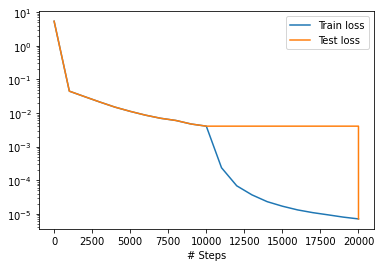

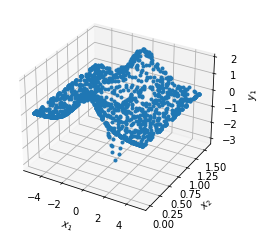

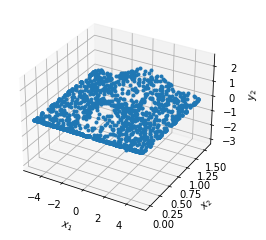

In [9]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True) 

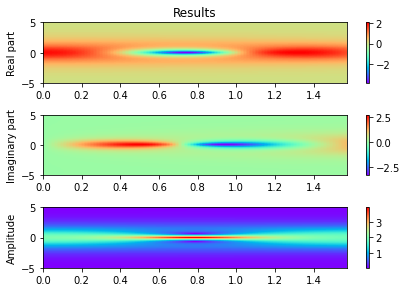

In [10]:
prediction = model.predict(X_star, operator=None)

u = griddata(X_star, prediction[:, 0], (X, T), method="cubic")
v = griddata(X_star, prediction[:, 1], (X, T), method="cubic")
h = np.sqrt(u ** 2 + v ** 2)

fig, ax = plt.subplots(3)
plt.tight_layout()

ax[0].set_title("Results")
ax[0].set_ylabel("Real part")
im1 = ax[0].imshow(
    u.T,
    interpolation="nearest",
    cmap='rainbow',
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
fig.colorbar(im1, ax=ax[0])

ax[1].set_ylabel("Imaginary part")
im2 = ax[1].imshow(
    v.T,
    interpolation="nearest",
    cmap='rainbow',
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
fig.colorbar(im2, ax=ax[1])

ax[2].set_ylabel("Amplitude")
im3 = ax[2].imshow(
    h.T,
    interpolation="nearest",
    cmap='rainbow',
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
fig.colorbar(im3, ax=ax[2])

plt.show()

También podemos ver el residuo de la red

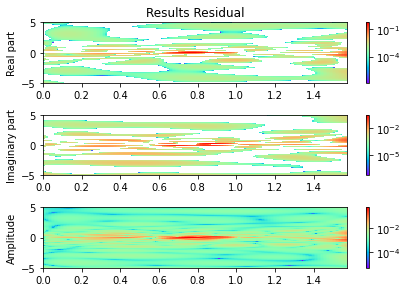

In [11]:
import matplotlib
prediction = model.predict(X_star, operator=pde)

u = griddata(X_star, prediction[0][:].reshape((len(prediction[0][:]),)), (X, T), method="cubic")
v = griddata(X_star, prediction[1][:].reshape((len(prediction[1][:]),)), (X, T), method="cubic")
h = np.sqrt(u ** 2 + v ** 2)

fig, ax = plt.subplots(3)
plt.tight_layout()

ax[0].set_title("Results Residual")
ax[0].set_ylabel("Real part")
im1 = ax[0].imshow(
    u.T,
    interpolation="nearest",
    cmap='rainbow',
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
    norm=matplotlib.colors.LogNorm(),
)
fig.colorbar(im1, ax=ax[0])

ax[1].set_ylabel("Imaginary part")
im2 = ax[1].imshow(
    v.T,
    interpolation="nearest",
    cmap='rainbow',
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
    norm=matplotlib.colors.LogNorm(),
)
fig.colorbar(im2, ax=ax[1])

ax[2].set_ylabel("Amplitude")
im3 = ax[2].imshow(
    h.T,
    interpolation="nearest",
    cmap='rainbow',
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
    norm=matplotlib.colors.LogNorm(),
)
fig.colorbar(im3, ax=ax[2])

plt.show()